## Cycling through data science <img src="../images/bicycle32.png" style="float:right">

Gather features which might help predict the number of bike users in any given day in DC, and evaluate the significance of those features and the robustness of the predictions.

This is essentially a linear regression problem. Linear regression problems are inference problems in that we infer, or predict, parameters of a population from a sample. They are also specifically supervised learning problems that entail building a model to make predictions about a continuous target variable (where the variable is comprised of uncountable values).

### Import libraries and set parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 5_000
sns.set(style="darkgrid")
%matplotlib inline

### Define functions to be used in this notebook

In [2]:
# Function prepare_data: Rename and rearrange columns and convert to datetime format where appropriate
# Input df: dataframe object
def prepare_data(df):
    # Convert column names to lowercase with spaces replaced by underscores
    df.columns = df.columns.str.lower().str.replace(' ', '_').tolist() 
    # Convert 'dteday' to datetime
    df[['dteday']] = df[['dteday']].apply(pd.to_datetime)
    # Rename columns
    df = df.rename(columns={
        'instant': 'id',
        'dteday': 'date',
        'season': 'season',
        'yr': 'year',
        'mnth': 'month',
        'holiday': 'is_holiday',
        'weekday': 'weekday',
        'workingday': 'is_workingday',
        'weathersit': 'weather',
        'temp': 'temp',
        'atemp': 'temp_feel',
        'hum': 'humdity',
        'windspeed': 'windspeed',
        'casual': 'casual',
        'registered': 'registered',
        'cnt': 'count'})
    return df

In [3]:
# Function count_users_by: Count the number of users in a day ('count') grouped by the category specified
#  Input df: dataframe object
#        category: the particular column that the count should be grouped by
def count_users_by(df, category):
    category_sum = df.groupby(category)['count'].sum()
    category_count = df.groupby(category)['count'].count()
    print(f"Counts: {category_count}")
    print(f"Sum: {category_sum}")
    ax = sns.barplot(category_sum.index, category_sum.values)

In [4]:
# Function fit_model: Returns optimal fitted model
#  Input X: Feature set (from training data)
#        y: Target values (from training data)
#        model_name: Default='lr'. Abbreviation/name of model (to be used to identify model in Pipeline)
#        model_type: Default=LinearRegression(). Model to use to fit data. Must be imported accordingly and corresponds to model_name
#        parameters: Default={'polynomial__degree': [1, 2]}. Parameters to be tuned in GridSearchCV. Must correspond to arguments for model_type.
def fit_model(X, y, model_name='mlr', model_type=LinearRegression(), parameters={'polynomial__include_bias': False, 'polynomial__degree': [1, 2]}):
    # Build pipeline to engineer features and fit model
    pm = Pipeline([
        ('polynomial', PolynomialFeatures()),
        ('scale', StandardScaler()),
        (model_name, model_type)
    ])
    model = pm.fit(X_train, y_train)
    
    # Build grid using pipeline to fit model
    parameters = parameters
    grid = GridSearchCV(pm, parameters)
    model_optimal = grid.fit(X_train, y_train)

    # Print best attributes
    best_params = grid.best_params_
    best_score = grid.best_score_
    print(f'For model: {model_type}')
    print(f'The best parameters are: {best_params}')
    print(f'The best score is: {best_score:.4f}')
    
    return model_optimal

In [5]:
# Function evaluate_model: Evaluate model
#  Input model: Model object containing fitted data
#        X_train, X_test, y_train, y_test: Training and testing values for features and target
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Evaluate training data
    y_hat_train = model.predict(X_train)
    kf_train = KFold(shuffle=True, random_state=42)
    cvs_train = cross_val_score(model, X_train, y_train, cv=kf_train).mean()
    score_train = model.score(X_train, y_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_hat_train))

    # Evaluate testing data
    y_hat_test = model.predict(X_test)
    kf_test = KFold(shuffle=True, random_state=42)
    cvs_test = cross_val_score(model, X_test, y_test, cv=kf_test).mean()
    score_test = model.score(X_test, y_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_hat_test))
    
    # Print results
    print(f'cvs mean score on training data: {cvs_train:.4f}')
    print(f'cvs mean score on testing data: {cvs_test:.4f}')
    
    print(f'Score on training data: {score_train:.4f}')
    print(f'Score on testing data: {score_test:.4f}')
    
    print(f'RMSE on training data: {rmse_train:.4f}')
    print(f'RMSE on testing data: {rmse_test:.4f}')

### Define problem

*Business problem*: Gather and utilize features which might help predict the number of bike users in any given day in DC.  
*Data science problem*: Given a set of weather and time variables, predict the number of bike users in a given day.  

### Gather data

In [6]:
# Read in dataset
df = pd.read_csv('../data/day.csv')

#### Data table
- id: record index
- date : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- year : year (0: 2011, 1:2012)
- month : month ( 1 to 12)
- is_holiday : whether day is holiday or not
- weekday : day of the week
- is_workingday : if day is neither weekend nor holiday is 1, otherwise is 0
- weather : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized daily temperature in Celsius
- temp_feel : Normalized daily feeling temperature in Celsius
- humidity: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- count: count of total rental bikes including both casual and registered 

### Explore and transform data

In [7]:
# Prepare dataset
df = prepare_data(df)

In [8]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
id               731 non-null int64
date             731 non-null datetime64[ns]
season           731 non-null int64
year             731 non-null int64
month            731 non-null int64
is_holiday       731 non-null int64
weekday          731 non-null int64
is_workingday    731 non-null int64
weather          731 non-null int64
temp             731 non-null float64
temp_feel        731 non-null float64
humdity          731 non-null float64
windspeed        731 non-null float64
casual           731 non-null int64
registered       731 non-null int64
count            731 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(11)
memory usage: 91.5 KB


In [9]:
# Header
df.head()

,id,date,season,year,month,is_holiday,weekday,is_workingday,weather,temp,temp_feel,humdity,windspeed,casual,registered,count
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [10]:
# Identify columns of interest for feature and target set
columns_of_interest = df.columns.difference(['id', 'date', 'casual', 'registered'])
df = df[columns_of_interest]

#### Identify cateogrical variables

Identify each categorical variable and map to numeric value. Then identify as either nominal or ordinal. If nominal, then convert to dummy and if ordinal, then convert to appropriate scale.
- season: ordinal values from 1 to 4
- year: ordinal values from 0 to 2
- month: ordinal values from 1 to 12
- is_holiday: nominal values from 0 to 1
- weekday: ordinal values from 0 to 6
- is_workingday: nominal values from 0 to 1
- weather: nominal values from 1 to 4

Counts: season
1    181
2    184
3    188
4    178
Name: count, dtype: int64
Sum: season
1     471348
2     918589
3    1061129
4     841613
Name: count, dtype: int64


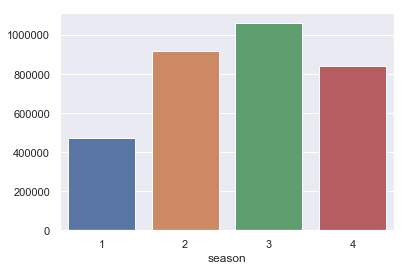

In [11]:
# Column: season
count_users_by(df, 'season')

Counts: year
0    365
1    366
Name: count, dtype: int64
Sum: year
0    1243103
1    2049576
Name: count, dtype: int64


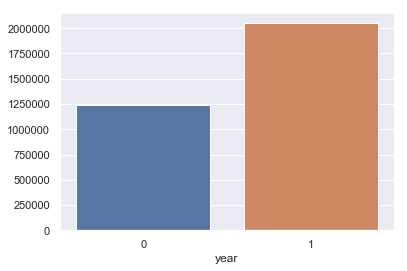

In [12]:
# Column: year
count_users_by(df, 'year')

Counts: month
1     62
2     57
3     62
4     60
5     62
6     60
7     62
8     62
9     60
10    62
11    60
12    62
Name: count, dtype: int64
Sum: month
1     134933
2     151352
3     228920
4     269094
5     331686
6     346342
7     344948
8     351194
9     345991
10    322352
11    254831
12    211036
Name: count, dtype: int64


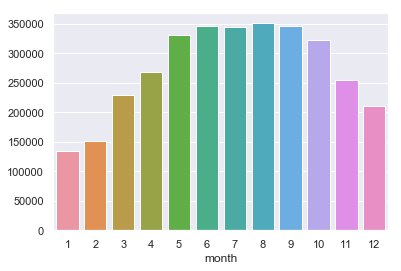

In [13]:
# Column: month
count_users_by(df, 'month')

Counts: is_holiday
0    710
1     21
Name: count, dtype: int64
Sum: is_holiday
0    3214244
1      78435
Name: count, dtype: int64


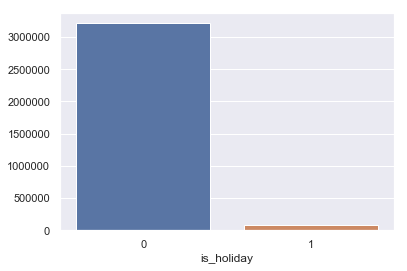

In [14]:
# Column: is_holiday
count_users_by(df, 'is_holiday')

Counts: weekday
0    105
1    105
2    104
3    104
4    104
5    104
6    105
Name: count, dtype: int64
Sum: weekday
0    444027
1    455503
2    469109
3    473048
4    485395
5    487790
6    477807
Name: count, dtype: int64


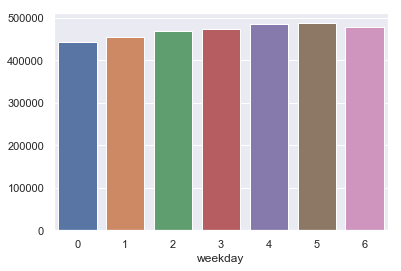

In [15]:
# Column: weekday
count_users_by(df, 'weekday')

Counts: is_workingday
0    231
1    500
Name: count, dtype: int64
Sum: is_workingday
0    1000269
1    2292410
Name: count, dtype: int64


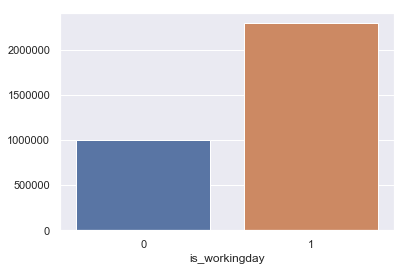

In [16]:
# Column: is_workingday
count_users_by(df, 'is_workingday')

Counts: weather
1    463
2    247
3     21
Name: count, dtype: int64
Sum: weather
1    2257952
2     996858
3      37869
Name: count, dtype: int64


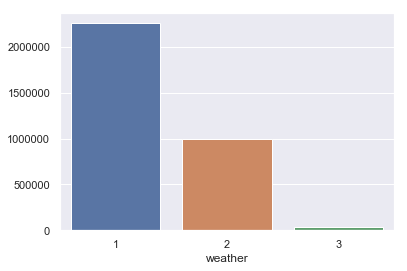

In [17]:
# Column: weather
count_users_by(df, 'weather')

In [18]:
# Convert nominal variables to categorical
df = pd.get_dummies(df, columns=['is_holiday', 'is_workingday', 'weather'], drop_first=True)

In [19]:
# Check if all values are numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
count              731 non-null int64
humdity            731 non-null float64
month              731 non-null int64
season             731 non-null int64
temp               731 non-null float64
temp_feel          731 non-null float64
weekday            731 non-null int64
windspeed          731 non-null float64
year               731 non-null int64
is_holiday_1       731 non-null uint8
is_workingday_1    731 non-null uint8
weather_2          731 non-null uint8
weather_3          731 non-null uint8
dtypes: float64(4), int64(5), uint8(4)
memory usage: 54.3 KB


In [20]:
# Header
df.head()

,count,humdity,month,season,temp,temp_feel,weekday,windspeed,year,is_holiday_1,is_workingday_1,weather_2,weather_3
0,985,0.805833,1,1,0.344167,0.363625,6,0.160446,0,0,0,1,0
1,801,0.696087,1,1,0.363478,0.353739,0,0.248539,0,0,0,1,0
2,1349,0.437273,1,1,0.196364,0.189405,1,0.248309,0,0,1,0,0
3,1562,0.590435,1,1,0.200000,0.212122,2,0.160296,0,0,1,0,0
4,1600,0.436957,1,1,0.226957,0.229270,3,0.186900,0,0,1,0,0


In [21]:
# Define target and feature variables
target = ['count']
features = df.columns.difference(['count'])
y = df[target]
X = df[features]

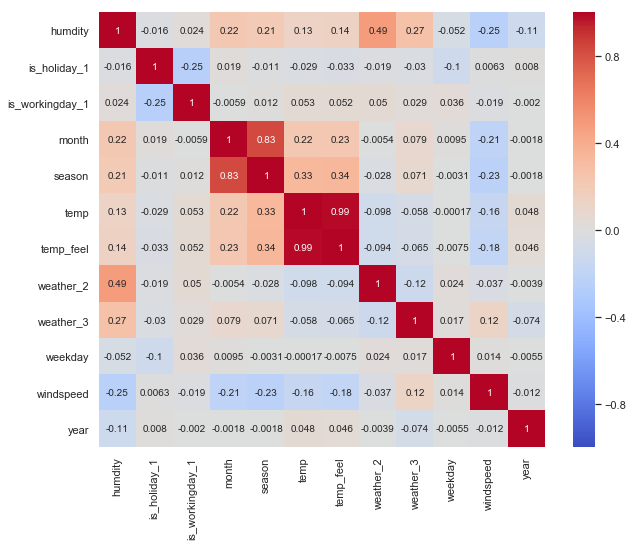

In [22]:
# Observe correlations between feature variables to appreciate multicollinearity
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1);

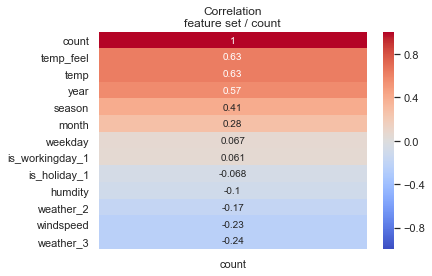

In [23]:
# Discover how feature variables correlate to target
df_corr = df.corr()[['count']].sort_values('count', ascending=False)
plt.title('Correlation\nfeature set / count')
sns.heatmap(df_corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1);

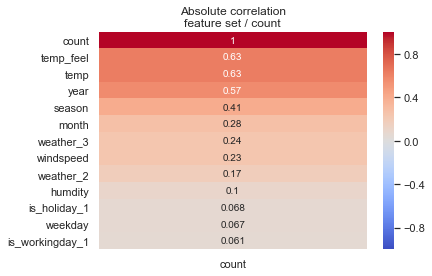

In [24]:
# Discover how feature variables correlate to target (absolute values of correlations)
df_corr_abs = df.corr()[['count']].abs().sort_values('count', ascending=False)
plt.title('Absolute correlation\nfeature set / count')
sns.heatmap(df_corr_abs, cmap='coolwarm', annot=True, vmin=-1, vmax=1);

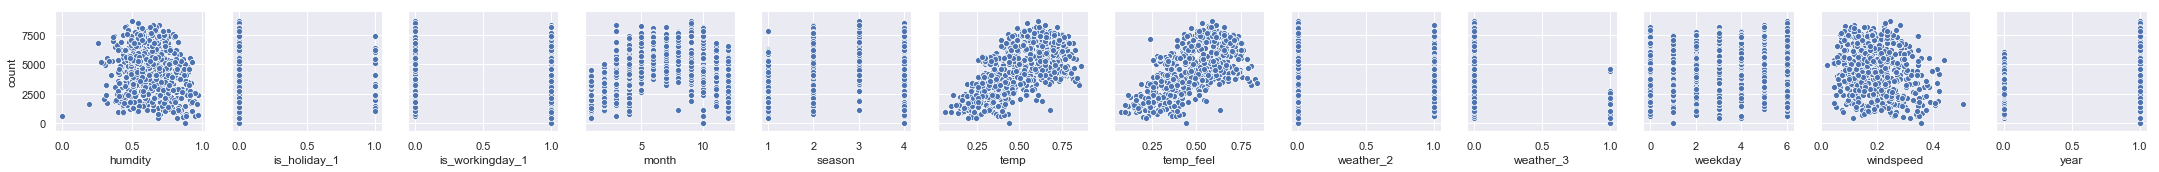

In [25]:
# Observe relationship of target variable to features
sns.pairplot(df, y_vars=['count'], x_vars=features);

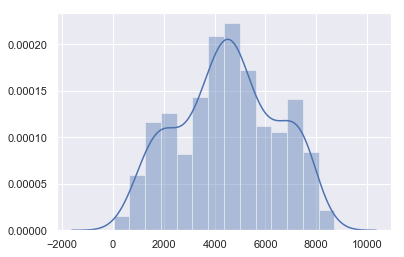

In [26]:
# Distribution of target variable
sns.distplot(y);

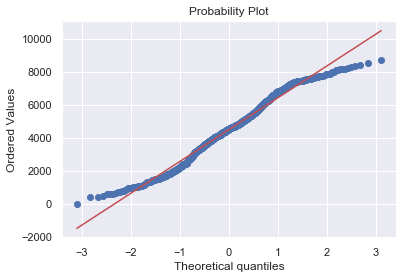

In [27]:
# Normality of target variable
stats.probplot(y['count'].tolist(), dist="norm", plot=plt)
plt.show();

In [28]:
# Split the data into training and testing datasets
X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=42, train_size=0.75)

#### Transform data

Transformation of data using polynomial features and scaling is built into the fit_model function under the *Build and fit model* section of this notebook.

### Build, fit, and evaluate model

#### 1. Baseline prediction

In [29]:
# Baseline prediction (mean value of target variable)
baseline_prediction = y_train.mean()[0]
baseline_prediction
f"The mean number of bike users on any given day is {baseline_prediction:,.0f}."

'The mean number of bike users on any given day is 4,575.'

#### 2. Multiple linear regression 

In [30]:
parameters = {
    'polynomial__degree': [1, 2, 3],
    'mlr__n_jobs': [-2]
}
mlr = fit_model(X_train, y_train, model_name='mlr', model_type=LinearRegression(), parameters=parameters)

For model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
The best parameters are: {'mlr__n_jobs': -2, 'polynomial__degree': 1}
The best score is: 0.7789


In [31]:
evaluate_model(mlr, X_train, X_test, y_train, y_test)

cvs mean score on training data: 0.7772
cvs mean score on testing data: 0.8194
Score on training data: 0.7918
Score on testing data: 0.8322
RMSE on training data: 876.8365
RMSE on testing data: 804.0642


#### 3. Multiple linear regression with ridge regularization 

In [32]:
parameters = {
    'polynomial__degree': [1, 2, 3],
    'mlr_ridge__alpha': np.logspace(0, 5, 200)
}
mlr_ridge = fit_model(X_train, y_train, model_name='mlr_ridge', model_type=Ridge(), parameters=parameters)

For model: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
The best parameters are: {'mlr_ridge__alpha': 2.5235391704347663, 'polynomial__degree': 3}
The best score is: 0.8379


In [33]:
evaluate_model(mlr_ridge, X_train, X_test, y_train, y_test)

cvs mean score on training data: 0.8100
cvs mean score on testing data: 0.8227
Score on training data: 0.9364
Score on testing data: 0.8682
RMSE on training data: 484.5169
RMSE on testing data: 712.7435


#### 4. Multiple linear regression with lasso regularization 

In [34]:
parameters = {
    'polynomial__degree': [1, 2, 3],
    'mlr_lasso__alpha': np.arange(0.001, 0.15, 0.0025)
}
mlr_lasso = fit_model(X_train, y_train, model_name='mlr_lasso', model_type=Lasso(), parameters=parameters)

For model: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
The best parameters are: {'mlr_lasso__alpha': 0.14849999999999999, 'polynomial__degree': 2}
The best score is: 0.8025


In [35]:
evaluate_model(mlr_lasso, X_train, X_test, y_train, y_test)

cvs mean score on training data: 0.7406
cvs mean score on testing data: 0.8021
Score on training data: 0.8970
Score on testing data: 0.8511
RMSE on training data: 616.7921
RMSE on testing data: 757.4441


#### 5. Multiple linear regression with elasticnet regularization 

In [36]:
parameters = {
    'polynomial__degree': [1, 2, 3],
    'mlr_enet__alpha': np.arange(0.001, 0.15, 0.0025)
}
mlr_enet = fit_model(X_train, y_train, model_name='mlr_enet', model_type=ElasticNet(), parameters=parameters)

For model: ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
The best parameters are: {'mlr_enet__alpha': 0.018500000000000003, 'polynomial__degree': 3}
The best score is: 0.8480


In [37]:
evaluate_model(mlr_enet, X_train, X_test, y_train, y_test)

cvs mean score on training data: 0.8064
cvs mean score on testing data: 0.8226
Score on training data: 0.9302
Score on testing data: 0.8705
RMSE on training data: 507.7820
RMSE on testing data: 706.5110


### Answer problem

Use the best model, in terms of bias-variance trade-off to compare predictions to test data.

In [38]:
# Generate the predictions using the best model and compare to test data
y_test_hat = mlr_enet.predict(X_test)
predictions = y_test
predictions['y_test_hat'] = y_test_hat
predictions = predictions.rename(columns={'count': 'y_test'})

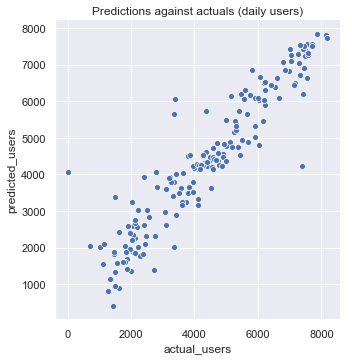

In [39]:
# Plot predictions against test data
sns.relplot(x='y_test', y='y_test_hat', data=predictions)
plt.xlabel('actual_users')
plt.ylabel('predicted_users')
plt.title('Predictions against actuals (daily users)');